In [96]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import toeplitz
import time

import tt
from tt.optimize import tt_min

In [54]:
# f(x1, x2) = (x1 - 0.2)**2 + (x2 - 0.5)**2
def square(x):
    # x has shape [number of samples, 2]
    
    if len(x.shape) > 1:
        res = (x[:, 0] - 0.2)**2 + (x[:, 1] - 0.5)**2
    else:
        res = (x[0] - 0.2)**2 + (x[1] - 0.5)**2
        
    print(res.shape)
    print('====================')
    
    return res

#minimum at point [0.2, 0.5]

In [55]:
bounds_min = 0
bounds_max = 1

d = 2   # dimension of space
n0 = 10

rmax = 3
nswp = 5

val, x_full = tt_min.min_func(lambda arg: square(arg), 
                              bounds_min = 0, 
                              bounds_max = 1,
                              d = 2,
                              rmax = 5, 
                              n0 = 100, 
                              nswp = 5, 
                              verb = False, 
                              smooth_fun = None)

print('TT:', x_full, val)
print('correct:', [0.2, 0.5], 0)

(500,)
()
(600,)
()
(600,)
(700,)
(700,)
(600,)
(600,)
(700,)
(700,)
(600,)
TT: [0.2020202  0.49494949] 2.958881746760517e-05
correct: [0.2, 0.5] 0


100%|██████████| 199/199 [00:00<00:00, 208.67it/s]


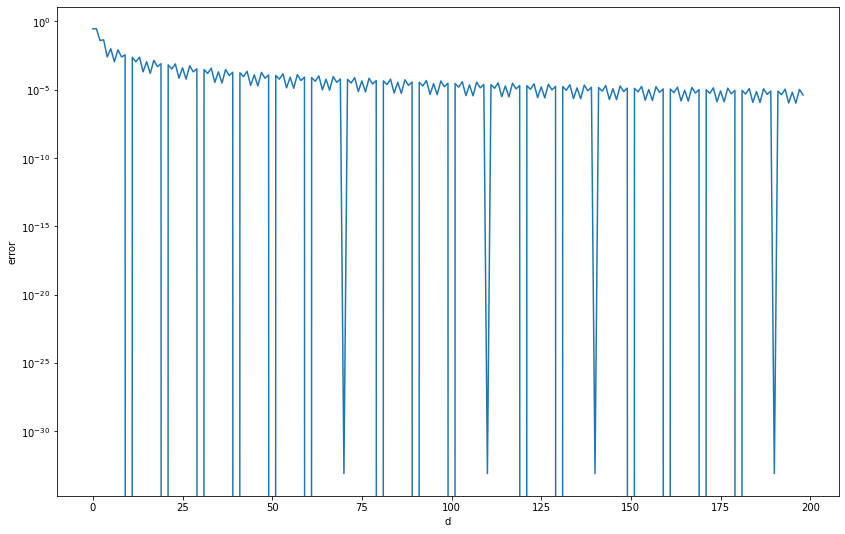

In [31]:
# d_x = []
d_val = []
for i in tqdm(range(1,200)):
    val, x_full = tt_min.min_func(lambda arg: square(arg), 
                              bounds_min = 0, 
                              bounds_max = 1,
                              d = 2,
                              rmax = 5, 
                              n0 = i, 
                              nswp = 5, 
                              verb = False, 
                              smooth_fun = None)
#     d_x.append(x_full)
    d_val.append(val)

plt.figure(figsize=(14,9))
plt.plot(d_val)
plt.ylabel('error')
plt.xlabel('d')
plt.yscale('log')
plt.show()

# Task

In [97]:
def Qubo(x,A):

    res = []
    for elem in x:
        elem = np.array(elem, dtype=np.int64)
        res.append(elem.dot(A.dot(elem)))
    res = np.array(res)
    
    return res

In [102]:
d = 20
l = np.zeros(d-2)
p = np.array([-2,1])
l = np.concatenate((p, l), axis=0)
Q = toeplitz(l, l)
# print(Q)

In [103]:
def int_2_bin(a, d):
    s = bin(a)
    s = s[2:]
    s = s.rjust(d, '0')
    s = np.array(list(s), dtype=np.int64)
    return s

In [66]:
min = 1e7
number = 0
for i in tqdm(range(2**d)):
    x = int_2_bin(i,d)
    f = x.dot(Q.dot(x))
    if (f < min):
        min = f
        number = i
        
clear_res = int_2_bin(number,d)
print('correct:', clear_res)

100%|██████████| 4194304/4194304 [00:21<00:00, 197474.84it/s]

correct: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [104]:
clear_res = []
for i in range(d):
    clear_res.append((d-i)%2)
clear_res = np.array(clear_res)

In [105]:
start_time = time.time()

val, x_full = tt_min.min_func(lambda arg: Qubo(arg,Q), 
                              bounds_min = 0, 
                              bounds_max = 1,
                              d = d,
                              rmax = 5, 
                              n0 = 2, 
                              nswp = 10, 
                              verb = False, 
                              smooth_fun = None)

x_full = np.array(x_full, dtype=np.int64)
print('correct:', clear_res)
print('TT:', x_full)
# val give smth strange instead of error_value, so I compute err_val as percent of wrong bits (bit error ratio)
print('error', sum(x_full^clear_res)/d)
print("--- %s seconds ---" % (time.time() - start_time))

correct: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
TT: [1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
error 0.15
--- 0.09442973136901855 seconds ---


# Dependence

In [77]:
def whole_qubo(d, nswp, rmax):
    
    l = np.zeros(d-2)
    p = np.array([-2,1])
    l = np.concatenate((p, l), axis=0)
    Q = toeplitz(l, l)
    
#     min = 1e7
#     number = 0
#     for i in range(2**d):
#         x = int_2_bin(i,d)
#         f = x.dot(Q.dot(x))
#         if (f < min):
#             min = f
#             number = i

#     clear_res = int_2_bin(number,d)
    clear_res = []
    for i in range(d):
        clear_res.append((d-i)%2)
    clear_res = np.array(clear_res)
#     print('correct:', clear_res)
    
    val, x_full = tt_min.min_func(lambda arg: Qubo(arg, Q), 
                              bounds_min = 0, 
                              bounds_max = 1,
                              d = d,
                              rmax = rmax, 
                              n0 = 2, 
                              nswp = nswp, 
                              verb = False, 
                              smooth_fun = None)
    
    x_full = np.array(x_full, dtype=np.int64)
#     print('TT:', x_full)
    error = np.sum(x_full^clear_res)/d
    return error

100%|██████████| 97/97 [00:54<00:00,  1.78it/s]


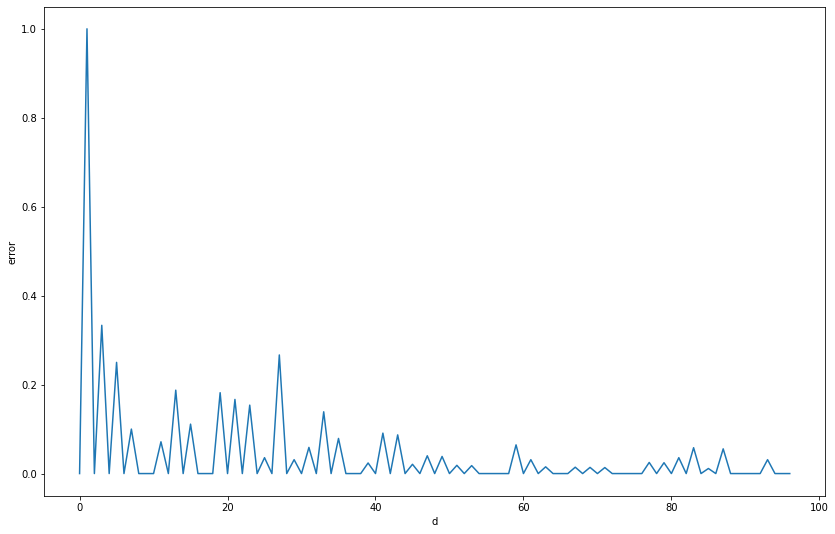

In [110]:
# nswp = 20, rmax = 5

errs = []
for d in tqdm(range(3,100)):
    errs.append(whole_qubo(d, 20, 5))

plt.figure(figsize=(14,9))
plt.plot(errs)
plt.xlabel('d')
plt.ylabel('error')
plt.show()

In [114]:
# d = 14, rmax = 5

errs = []
for nswp in tqdm(range(5,100)):
    errs.append(whole_qubo(14, nswp, 5))

100%|██████████| 95/95 [00:24<00:00,  3.89it/s]


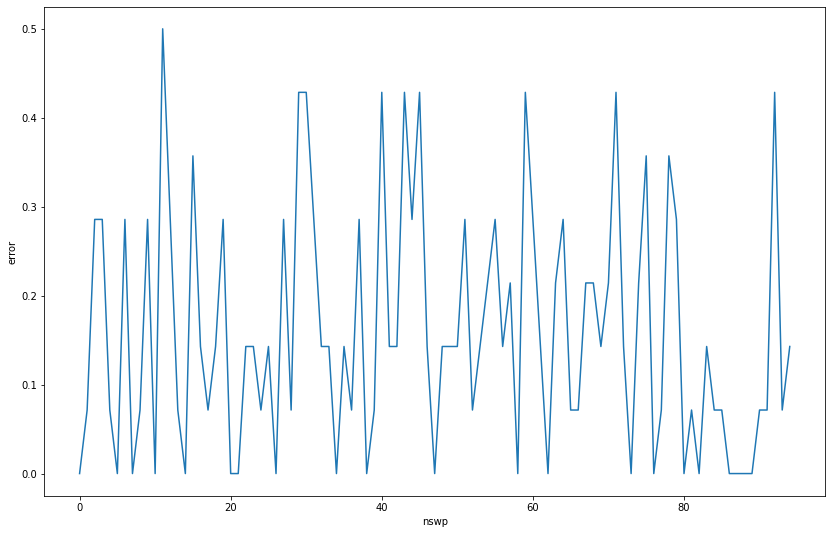

In [115]:
plt.figure(figsize=(14,9))
plt.plot(errs)
plt.xlabel('nswp')
plt.ylabel('error')
plt.show()

In [116]:
# d = 14, nswp = 10

errs = []
for rmax in tqdm(range(2,50)):
    errs.append(whole_qubo(14, 10, rmax))

100%|██████████| 48/48 [00:25<00:00,  1.85it/s]


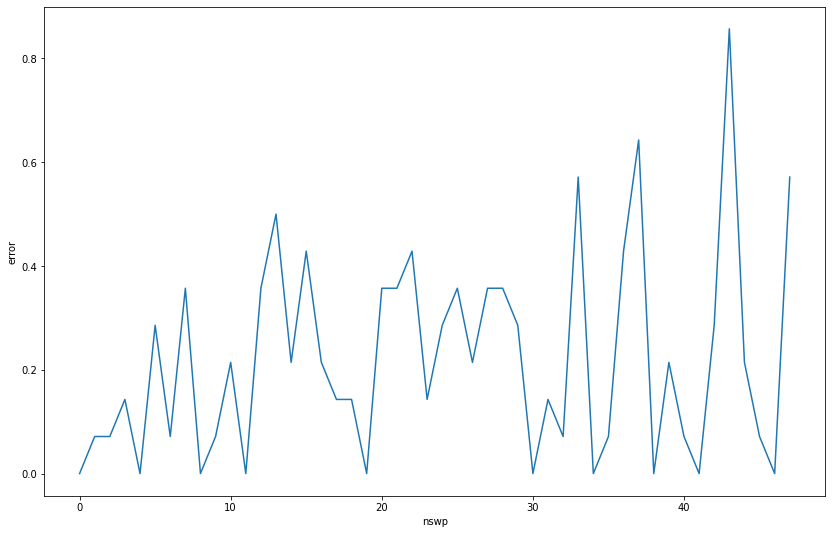

In [117]:
plt.figure(figsize=(14,9))
plt.plot(errs)
plt.xlabel('nswp')
plt.ylabel('error')
plt.show()

In [108]:
errs = []
times = []
for d in tqdm(range(3,150)):
    start_time = time.time()
    errs.append(whole_qubo(d, 10, 5))
    times.append(time.time() - start_time)

100%|██████████| 147/147 [02:34<00:00,  1.05s/it]


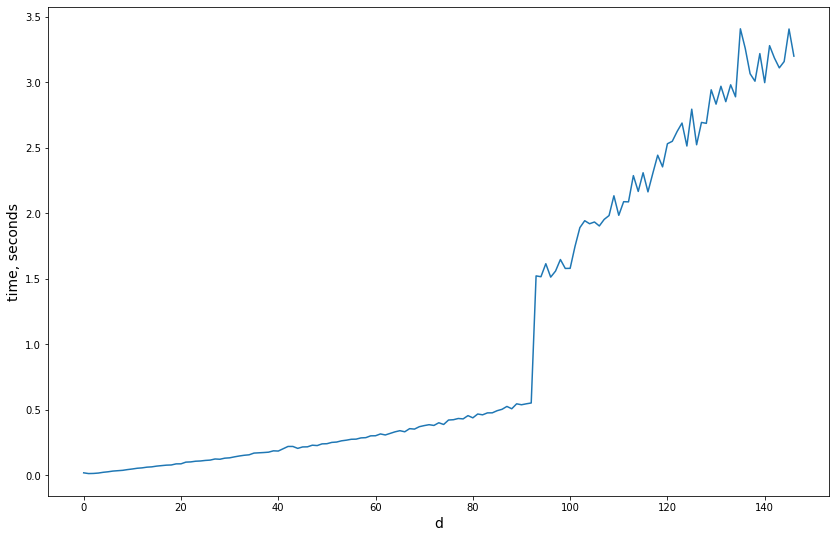

In [109]:
plt.figure(figsize=(14,9))
plt.plot(times)
plt.xlabel('d', fontsize='14')
plt.ylabel('time, seconds', fontsize='14')
plt.show()